## Observational overdensities

Comparison to observed overdensities.

In [133]:
import pandas as pd
import numpy as np

import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from methods import bhattacharyya
from methods import plotit

from astropy.cosmology import Planck13

In [134]:
print "R:", 7 / Planck13.h, "cMpc"

R: 10.3290541538 cMpc


### Franck & McGaugh +16

Write protocluster candidate data in to a dataframe for ease of use. Redshift depth given by $z \pm \sigma_{z}$.

In [135]:
name = ['CCPC-z27-002','CCPC-z29-001','CCPC-z29-002','CCPC-z30-001','CCPC-z30-003','CCPC-z31-003',
        'CCPC-z31-004','CCPC-z31-005','CCPC-z32-002','CCPC-z33-002','CCPC-z35-001','CCPC-z36-001']

redshift = [2.772,2.918,2.919,3.035,3.096,3.133,3.146,3.152,3.234,3.372,3.597,3.644]
deltaz = [0.007,0.005,0.009,0.005,0.008,0.008,0.006,0.007,0.003,0.008,0.003,0.003]

In [136]:
dat = pd.DataFrame(data=[redshift, deltaz]).T
dat.index = name
dat.columns = ['redshift','deltaz']

Calculate $\Delta z$ in $h^{-1} \, \mathrm{cMpc}$

In [137]:
dat['deltac'] = (Planck13.comoving_distance(dat.redshift+dat.deltaz) - \
                 Planck13.comoving_distance(dat.redshift-dat.deltaz)) / 2 * Planck13.h

Add empty columns for calculated protocluster probabilities, and nearest redshift snapshot in Millennium.

In [138]:
dat['protocluster probability'] = pd.Series()
dat['high mass probability'] = pd.Series()
dat['part probability'] = pd.Series()
dat['nearest snap'] = [3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.95,3.95]

dat

,redshift,deltaz,deltac,protocluster probability,high mass probability,part probability,nearest snap
CCPC-z27-002,2.772,0.007,5.050439,NaN,NaN,NaN,3.10
CCPC-z29-001,2.918,0.005,3.415010,NaN,NaN,NaN,3.10
CCPC-z29-002,2.919,0.009,6.144762,NaN,NaN,NaN,3.10
CCPC-z30-001,3.035,0.005,3.272476,NaN,NaN,NaN,3.10
CCPC-z30-003,3.096,0.008,5.123117,NaN,NaN,NaN,3.10
CCPC-z31-003,3.133,0.008,5.056575,NaN,NaN,NaN,3.10
CCPC-z31-004,3.146,0.006,3.775142,NaN,NaN,NaN,3.10
CCPC-z31-005,3.152,0.007,4.395078,NaN,NaN,NaN,3.10
CCPC-z32-002,3.234,0.003,1.830712,NaN,NaN,NaN,3.10
CCPC-z33-002,3.372,0.008,4.658643,NaN,NaN,NaN,3.10


#### Load overdensity data

In [140]:
directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
out_directory ='../'

dgal = pcl.load(open(directory+'dgal_stellarMass10_z3p10_r7p0_random.pcl','rb'))

In [141]:
dgal.shape

(1, 9, 200000, 4)

Evaluate cluster probability ($P_{C}$)

The choice of $P_{lim}$ and $C_{lim}$ is complicated by the non-spherical aperture with highly varying depth. We use a constant value for both.

In [162]:
Plim = 0.3
Clim = 0.7

'CCPC-z32-002'

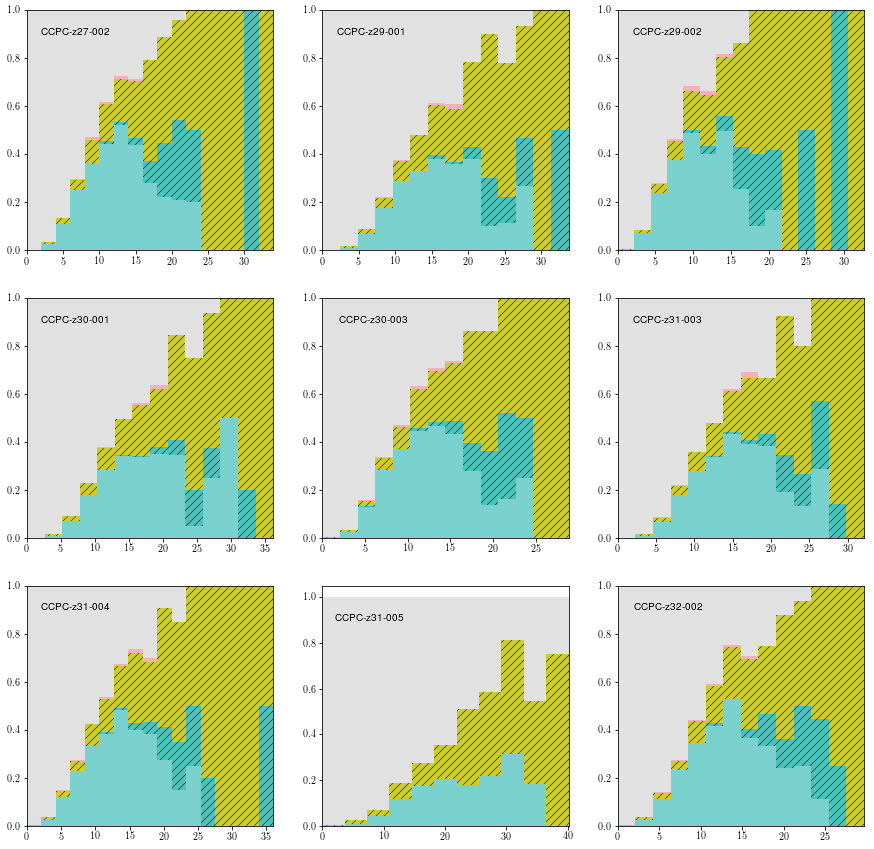

In [186]:
fig, ax = plt.subplots(3,3, figsize=(15,15))

ax = ax.flatten()

for i in range(9):
    plotit(ax[i], dgal, 0, i, axb=None, N=18, clim=Clim, plim=Plim)
    ax[i].text(2, 0.9, dat.index.values[i])

In [187]:
dat.index.values

array(['CCPC-z27-002', 'CCPC-z29-001', 'CCPC-z29-002', 'CCPC-z30-001',
       'CCPC-z30-003', 'CCPC-z31-003', 'CCPC-z31-004', 'CCPC-z31-005',
       'CCPC-z32-002', 'CCPC-z33-002', 'CCPC-z35-001', 'CCPC-z36-001'], dtype=object)

In [117]:
dat.ix['CCPC-z27-002']['protocluster probability'] = 0.62
dat.ix['CCPC-z27-002']['high mass probability'] = 0.15

dat.ix['CCPC-z29-001']['protocluster probability'] = 0.39
dat.ix['CCPC-z29-001']['high mass probability'] = 0.08

dat.ix['CCPC-z29-002']['protocluster probability'] = 0.65
dat.ix['CCPC-z29-002']['high mass probability'] = 0.15

In [125]:
dat

,redshift,deltaz,deltac,protocluster probability,high mass probability,part probability,nearest snap
CCPC-z27-002,2.772,0.007,5.050439,NaN,NaN,NaN,3.10
CCPC-z29-001,2.918,0.005,3.415010,NaN,NaN,NaN,3.10
CCPC-z29-002,2.919,0.009,6.144762,NaN,NaN,NaN,3.10
CCPC-z30-001,3.035,0.005,3.272476,NaN,NaN,NaN,3.10
CCPC-z30-003,3.096,0.008,5.123117,NaN,NaN,NaN,3.10
CCPC-z31-003,3.133,0.008,5.056575,NaN,NaN,NaN,3.10
CCPC-z31-004,3.146,0.006,3.775142,NaN,NaN,NaN,3.10
CCPC-z31-005,3.152,0.007,4.395078,NaN,NaN,NaN,3.10
CCPC-z32-002,3.234,0.003,1.830712,NaN,NaN,NaN,3.10
CCPC-z33-002,3.372,0.008,4.658643,NaN,NaN,NaN,3.10


Calculate descendant mass